In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from flows.base import Flow
from flows.affine import Planar, Radial
from flows.activation import PReLU
tfd = tfp.distributions

In [2]:
k = 2
n_layers = 4
prelu = PReLU()
planar = Planar(k)
radial = Radial(k)
transform = planar
for i in range(n_layers - 1):
    transform = planar(radial(transform))

In [3]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros((k,)))

In [4]:
flow = Flow(base_dist, transform, learning_rate=1.0E-4, name='affine_gaussian')

In [5]:
x1_samples = tfd.Normal(loc=2.0, scale=0.5).sample(1024)
x2_samples = tfd.Normal(loc=2.0*x1_samples**2.0, scale=0.1*tf.ones(x1_samples.shape)).sample()
x_samples = tf.stack([x2_samples, x1_samples], axis=1)

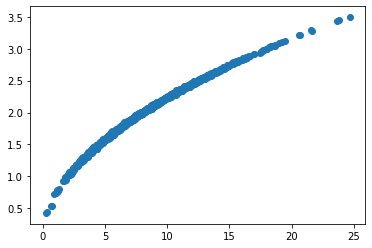

In [6]:
plt.scatter(x_samples[:,0], x_samples[:,1])

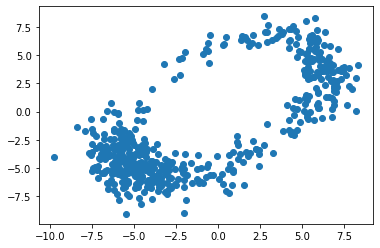

In [7]:
flow_dist_samples = flow.dist.sample(512)
plt.scatter(flow_dist_samples[:,0], flow_dist_samples[:,1])

In [8]:
print(x_samples[:1])
y = radial.forward(x_samples[:1])
print(y)
print(radial.inverse(y))
y = planar.forward(x_samples[:1])
print(y)
print(planar.inverse(y))

tf.Tensor([[6.0456405 1.7213502]], shape=(1, 2), dtype=float32)
tf.Tensor([[7.0116687 1.9731883]], shape=(1, 2), dtype=float32)
tf.Tensor([[6.0456405 1.7213502]], shape=(1, 2), dtype=float32)
tf.Tensor([[6.7525144 2.428224 ]], shape=(1, 2), dtype=float32)
tf.Tensor([[6.0456405 1.7213502]], shape=(1, 2), dtype=float32)


In [9]:
print(radial.inverse_log_det_jacobian(radial.forward(x_samples[:1]), event_ndims=1))

tf.Tensor([[-5.062112]], shape=(1, 1), dtype=float32)


W0904 12:30:06.091011 140022258857792 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x7f58d83a9bd8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.
W0904 12:30:06.095500 140022258857792 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x7f58d82678b8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env vari

W0904 12:30:06.131730 140022258857792 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x7f58d8146b38> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.
W0904 12:30:06.134669 140022258857792 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x7f58d8146c28> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env vari

W0904 12:30:06.177027 140022258857792 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x7f58d81546d8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.
W0904 12:30:06.180846 140022258857792 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x7f58d81547c8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env vari

(iteration 0) log loss: 22.674217224121094


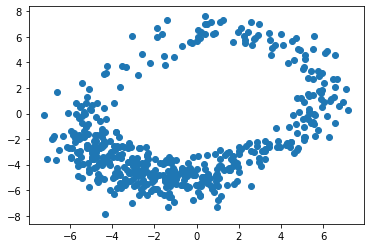

InvalidArgumentError: nan/inf gradient for b_1:0 : Tensor had NaN values
	 [[{{node VerifyFinite_48/CheckNumerics}}]] [Op:__inference_train_on_batch_16629]

In [10]:
for i in range(10000):
    log_loss, grads = flow.train_on_batch(x_samples)
    if i % 100 == 0:
        #vars_grads = list(zip(map(flow.trainable_variables), map(lambda g: g.numpy(), grads)))
        print(f'(iteration {i}) log loss: {log_loss.numpy()}')
    if i % 1000 == 0:
        samples = flow.dist.sample(512)
        plt.scatter(samples[:,0], samples[:,1])
        plt.show()